# Signature Map Inversion

In [1]:
# external packages
from esig.tosig import stream2logsig
import signatory as sg
import matplotlib.pyplot as plt
import numpy as np
import torch

# Buehler functionalities
from BuehlerVAE.src.utils.leadlag import leadlag
import BuehlerVAE.src.logsig_inversion as logsig_inversion

# own functionalities
from src.data.make_dataset import DataLoader
from src.features.data_transformer import Transformer


c:\Users\peter\OneDrive - TUM\Master TUM\Masterarbeit\MarketGenerators\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Prepare Data

In [2]:
# Specify the data loader parameters
n = 10
n_points = 21
nPeriods = 1.
brownian_motion_params = {"T": nPeriods, "n_points": n_points, "n": n}
gbm_params = {"S0": 1., "mu": 0.05, "sigma": 0.2, "T": nPeriods, "n_points": n_points, "n": n}
# from kou paper: https://www.researchgate.net/publication/222470707_A_jump-diffusion_model_for_option_pricing
# kou_params = {
#     "S0": 1., 
#     "mu": 0.15, 
#     "sigma": 0.2, 
#     "lambda_": 2.0, 
#     "p": 0.3, 
#     "eta1": 50., 
#     "eta2": 25., 
#     "T": nPeriods, 
#     "n_points": n_points, 
#     "n": n
# }
# own configuration:
kou_params = {
    "S0": 1., 
    "mu": 0.15, 
    "sigma": 0.2, 
    "lambda_": 1.5, 
    "p": 0.3, 
    "eta1": 20., 
    "eta2": 10., 
    "T": nPeriods, 
    "n_points": n_points, 
    "n": n
}

In [3]:
# Load different path types
bm_loader = DataLoader(method="Brownian_Motion", params=brownian_motion_params)
gbm_loader = DataLoader(method="GBM", params=gbm_params)
kou_loader = DataLoader(method="Kou_Jump_Diffusion", params=kou_params)
pathsBM, timesBM = bm_loader.create_dataset(output_type="np.ndarray")
pathsGBM, timesGBM = gbm_loader.create_dataset(output_type="np.ndarray")
pathsKOU, timesKOU = kou_loader.create_dataset(output_type="np.ndarray")

In [4]:
# Specify paths to analyze here
paths = pathsKOU
times = timesKOU

## Insertion Method (Signatory)

### Time augmented method

In [5]:
# convert paths to torch tensor for signatory library
paths_torch = Transformer().arrays_to_torch_tensor(times, paths)
# set the depth of the signature (or order) 
# if granularity equals depth, output will be of same format as input (depth = int(nPeriods/dt))
depth = 20
signatures = sg.signature(paths_torch, depth)
inverted_paths = sg.invert_signature(signatures, depth=depth, channels=2, initial_position=paths_torch[:, 0, :])
times_recovered, paths_recovered = Transformer().torch_tensor_to_arrays(inverted_paths)

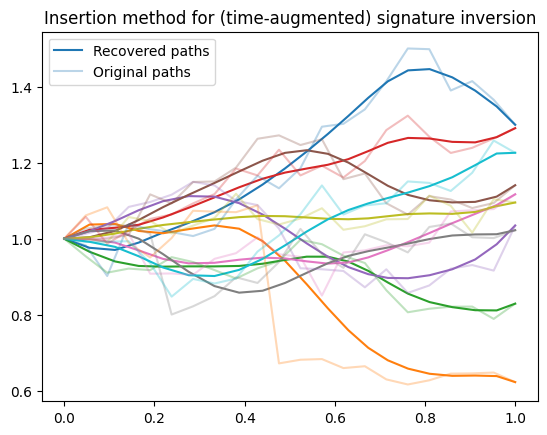

In [6]:
# Plot paths
for i in range(paths_recovered.shape[1]):
    plt.plot(times_recovered, paths_recovered[:,i], label='Recovered paths' if i == 0 else '')
# Reset the color cycle to make sure the original paths have the same color scheme
plt.gca().set_prop_cycle(None)
# Plot original paths with lower alpha
for i in range(paths.shape[1]):
    plt.plot(times, paths[:,i], alpha=0.3, label='Original paths' if i == 0 else '')
plt.title("Insertion method for (time-augmented) signature inversion")
plt.legend()
plt.show()


### lead-lag method

In [7]:
# convert paths to torch tensor for signatory library
# GOAL: SHAPE 10, 44(?), 2
for i in range(paths.shape[1]):
    leadlag_path = torch.from_numpy(leadlag(paths[:,i]))
    if i == 0:
        paths_torch_leadlag = leadlag_path.unsqueeze(0)
    else:
        paths_torch_leadlag = torch.cat((paths_torch_leadlag, leadlag_path.unsqueeze(0)), 0)
    
# set the depth of the signature (or order) 
# if granularity equals depth, output will be of same format as input (depth = int(nPeriods/dt))
depth = 20
signatures = sg.signature(paths_torch_leadlag, depth)
inverted_paths_leadlag = sg.invert_signature(signatures, depth=depth, channels=2, initial_position=paths_torch_leadlag[:, 0, :])
leadlag_recovered = inverted_paths_leadlag.numpy()

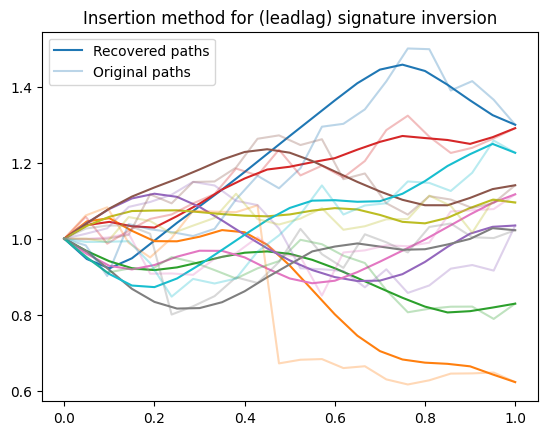

In [8]:
# Plot paths
for i in range(paths_recovered.shape[1]):
    plt.plot(np.linspace(0,nPeriods, depth+1), leadlag_recovered[i,:,1], label='Recovered paths' if i == 0 else '')
# Reset the color cycle to make sure the original paths have the same color scheme
plt.gca().set_prop_cycle(None)
# Plot original paths with lower alpha
for i in range(paths.shape[1]):
    plt.plot(times, paths[:,i], alpha=0.3, label='Original paths' if i == 0 else '')
plt.title("Insertion method for (leadlag) signature inversion")
plt.legend()
plt.show()

## Buehler log-signature Inversion

### lead-lag log-signature method

In [9]:
pip = 0.001
n_pips = 5 * 10
n_points = 22

n_iterations = 100
n_organisms = 100

logsig_order = 4
paths_recovered_buehler = []
for i in range(paths.shape[1]):
    current_path = paths[:,i]
    logsig = stream2logsig(leadlag(current_path), logsig_order)
    recovered_path, loss = logsig_inversion.train(
        logsig, logsig_order, n_iterations, n_organisms, n_points, pip, n_pips
    )
    
    paths_recovered_buehler.append(recovered_path+1)

Loss: 0.0233707073737109: 100%|██████████| 100/100 [00:05<00:00, 19.44it/s] 


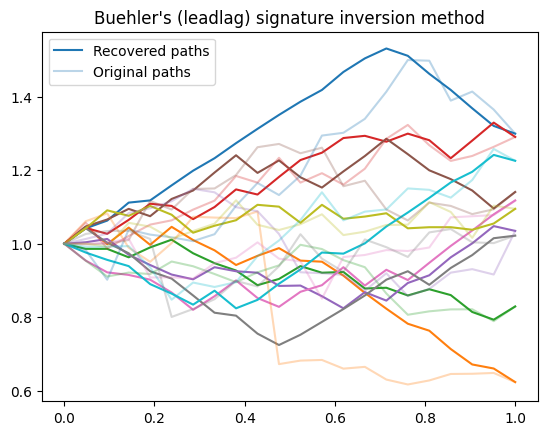

In [10]:
# Plot paths
for i in range(len(paths_recovered_buehler)):
    plt.plot(np.linspace(0, nPeriods, n_points), paths_recovered_buehler[i], label='Recovered paths' if i == 0 else '')
# Reset the color cycle to make sure the original paths have the same color scheme
plt.gca().set_prop_cycle(None)
# Plot original paths with lower alpha
for i in range(paths.shape[1]):
    plt.plot(times, paths[:,i], alpha=0.3, label='Original paths' if i == 0 else '')
plt.title("Buehler's (leadlag) signature inversion method")
plt.legend()
plt.show()

### Time augmented method

Note that the the `train` method of Buehler uses leadlag in its function. This is not methodologically sound if we use the time augmented method here and would need improvement.

In [11]:
paths_recovered_buehler_time = []
for i in range(paths.shape[1]):
    logsig = stream2logsig(np.column_stack((times, paths[:,i])), logsig_order)
    recovered_path, loss = logsig_inversion.train(
        logsig, logsig_order, n_iterations, n_organisms, n_points, pip, n_pips
    )
    
    paths_recovered_buehler_time.append(recovered_path+1)

  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.2381501836476261: 100%|██████████| 100/100 [00:05<00:00, 17.88it/s]


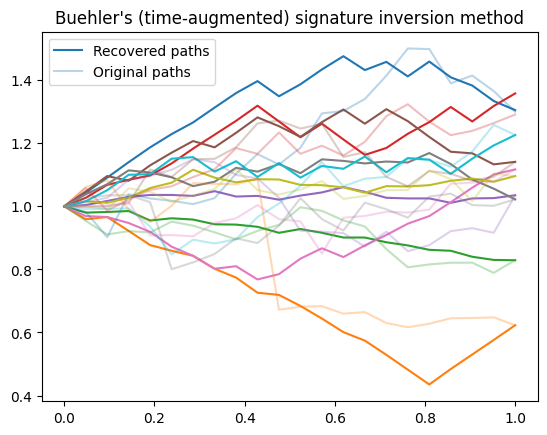

In [12]:
# Plot paths
for i in range(len(paths_recovered_buehler_time)):
    plt.plot(np.linspace(0, nPeriods, n_points), paths_recovered_buehler_time[i], label='Recovered paths' if i == 0 else '')
# Reset the color cycle to make sure the original paths have the same color scheme
plt.gca().set_prop_cycle(None)
# Plot original paths with lower alpha
for i in range(paths.shape[1]):
    plt.plot(times, paths[:,i], alpha=0.3, label='Original paths' if i == 0 else '')
plt.title("Buehler's (time-augmented) signature inversion method")
plt.legend()
plt.show()